In [2]:
!pip install pyhealth

In [13]:
!pip install torch torchvision numpy pandas scikit-learn matplotlib tqdm pillow pyhealth

In [41]:
!mkdir -p CXR8/images

# Step 0: Set up the dataset

In [3]:
from pyhealth.tasks import AgePredictionTask
from pyhealth.tasks.age_prediction import RegressionProcessor
from pyhealth.models.age_predictor import ChestXrayAgePredictor
import numpy as np
# Import from PyHealth
from pyhealth.datasets import ChestXray14Dataset
from pyhealth.trainer import Trainer
import torch



# Load dataset and set task
root = "./CXR8"
dataset = ChestXray14Dataset(root=root, download=False, partial=False)
task = AgePredictionTask()

# Set task with custom processor
dataset = dataset.set_task(
    task,
    output_processors={"age": RegressionProcessor()}
)
# Get total size
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)

# Create shuffled indices
np.random.seed(42)
indices = np.random.permutation(total_size)


Initializing ChestX-ray14 dataset from ./CXR8 (dev mode: False)
Scanning table: chestxray14 from /home/sagemaker-user/CXR8/chestxray14-metadata-pyhealth.csv
Setting task AgePrediction for ChestX-ray14 base dataset...
Generating samples with 1 worker(s)...
Collected dataframe with shape: (112120, 26)


Generating samples for AgePrediction with 1 worker:   2%|▏         | 636/30805 [00:00<00:35, 852.81it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  11%|█         | 3296/30805 [00:03<00:31, 861.70it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  12%|█▏        | 3581/30805 [00:04<00:31, 862.77it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  12%|█▏        | 3676/30805 [00:04<00:31, 861.72it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  21%|██        | 6336/30805 [00:07<00:28, 865.77it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  25%|██▍       | 7571/30805 [00:08<00:26, 863.76it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  42%|████▏     | 12891/30805 [00:14<00:20, 859.83it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  46%|████▌     | 14221/30805 [00:16<00:19, 860.41it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  48%|████▊     | 14696/30805 [00:17<00:18, 860.38it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  54%|█████▍    | 16596/30805 [00:19<00:16, 859.59it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  75%|███████▍  | 23056/30805 [00:26<00:09, 860.93it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  76%|███████▋  | 23531/30805 [00:27<00:08, 861.26it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  91%|█████████▏| 28186/30805 [00:32<00:03, 862.30it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker:  94%|█████████▍| 29041/30805 [00:33<00:02, 862.03it/s]

Skipping sample with age 0.0 outside valid range [1, 100]


Generating samples for AgePrediction with 1 worker: 100%|██████████| 30805/30805 [00:35<00:00, 862.57it/s]
Processing samples: 100%|██████████| 112106/112106 [25:56<00:00, 72.03it/s]

Generated 112106 samples for task AgePrediction


In [ ]:

# print(f"Train size: {len(train_ds)}")      # ~3499
# print(f"Validation size: {len(val_ds)}")   # ~749
# print(f"Test size: {len(test_ds)}")        # ~751

#Step 1: Set up the model

In [4]:

# Initialize model
model = ChestXrayAgePredictor(dataset=dataset)


Using cache found in /home/sagemaker-user/.cache/torch/hub/pytorch_vision_main


In [5]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)
data = next(iter(train_dataloader))
print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

loader size: train/val/test 89684 11211 11211


In [6]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3)


In [7]:
from tqdm import tqdm
import torch

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training"):
        images = batch['image'].to(device)
        # Convert list to tensor
        ages = torch.tensor(batch['age'], dtype=torch.float32).to(device)

        optimizer.zero_grad()
        outputs = model(image=images, age=ages)
        loss = outputs['loss']

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            images = batch['image'].to(device)
            # Convert list to tensor
            ages = torch.tensor(batch['age'], dtype=torch.float32).to(device)

            outputs = model(image=images, age=ages)
            loss = outputs['loss']

            total_loss += loss.item()
            predictions.extend(outputs['y_prob'].cpu().numpy())
            targets.extend(ages.cpu().numpy())

    return total_loss / len(loader), predictions, targets



# Step 2: Train and evaluate the model

In [32]:
num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}")

    # Validate
    val_loss, val_preds, val_targets = validate(model, val_dataloader, device)
    print(f"Val Loss: {val_loss:.4f}")

    # Evaluate using PyHealth's built-in metrics
    metrics = AgePredictionTask.evaluate(
        torch.tensor(val_targets),
        torch.tensor(val_preds)
    )
    print(f"Val MAE: {metrics['mae']:.2f} years")
    print(f"Val RMSE: {metrics['rmse']:.2f} years")
    print(f"Val Correlation: {metrics.get('correlation', 0):.3f}")
    print(f"Within 5 years: {metrics.get('within_5', 0)*100:.1f}%")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_age_predictor.pth')
        print("✓ Saved best model")


Epoch 1/5


Training: 100%|██████████| 351/351 [05:20<00:00,  1.10it/s]


Train Loss: 3.9059


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Val Loss: 3.2889
Val MAE: 3.66 years
Val RMSE: 4.97 years
Val Correlation: 0.954
Within 5 years: 75.4%
✓ Saved best model
Epoch 2/5


Training: 100%|██████████| 351/351 [05:21<00:00,  1.09it/s]


Train Loss: 3.5990


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Val Loss: 3.5147
Val MAE: 3.87 years
Val RMSE: 5.14 years
Val Correlation: 0.952
Within 5 years: 72.1%
Epoch 3/5


Training: 100%|██████████| 351/351 [05:21<00:00,  1.09it/s]


Train Loss: 3.4061


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Val Loss: 3.5023
Val MAE: 3.86 years
Val RMSE: 5.22 years
Val Correlation: 0.950
Within 5 years: 72.1%
Epoch 4/5


Training: 100%|██████████| 351/351 [05:21<00:00,  1.09it/s]


Train Loss: 3.1399


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]


Val Loss: 3.7124
Val MAE: 4.07 years
Val RMSE: 5.48 years
Val Correlation: 0.951
Within 5 years: 70.2%
Epoch 5/5


Training: 100%|██████████| 351/351 [05:21<00:00,  1.09it/s]


Train Loss: 3.0320


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.42it/s]

Val Loss: 3.5856
Val MAE: 3.95 years
Val RMSE: 5.31 years
Val Correlation: 0.949
Within 5 years: 71.1%


### With more epochs the training results get better. Below's results are run with 20+ epochs. Initial run has training Loss of 40

In [9]:
# Load best model
model.load_state_dict(torch.load('best_age_predictor.pth'))

# Test
test_loss, test_preds, test_targets = validate(model, test_dataloader, device)

# Final evaluation
test_metrics = AgePredictionTask.evaluate(
    torch.tensor(test_targets),
    torch.tensor(test_preds)
)

print("=== Final Test Results ===")
print(f"Test MAE: {test_metrics['mae']:.2f} years")
print(f"Test RMSE: {test_metrics['rmse']:.2f} years")
print(f"Test Correlation: {test_metrics.get('correlation', 0):.3f}")
print(f"Within 5 years: {test_metrics.get('within_5', 0)*100:.1f}%")
print(f"Within 10 years: {test_metrics.get('within_10', 0)*100:.1f}%")


Validating: 100%|██████████| 44/44 [00:30<00:00,  1.44it/s]

=== Final Test Results ===
Test MAE: 3.62 years
Test RMSE: 4.98 years
Test Correlation: 0.957
Within 5 years: 75.6%
Within 10 years: 94.5%


In [22]:
!pip install scikit-learn

# Step 3: Visualize results

In [24]:
import matplotlib.pyplot as plt
def visualize_age_predictions(true_ages, pred_ages, mae):
    """Visualize age prediction results"""
    plt.figure(figsize=(14, 5))
    
    # Scatter plot
    plt.subplot(1, 3, 1)
    plt.scatter(true_ages, pred_ages, alpha=0.3, s=10)
    plt.plot([0, 100], [0, 100], 'r--', label='Perfect prediction', linewidth=2)
    plt.xlabel('True Age (years)', fontsize=12)
    plt.ylabel('Predicted Age (years)', fontsize=12)
    plt.title(f'Age Prediction (MAE={mae:.2f} years)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    # Error distribution
    plt.subplot(1, 3, 2)
    errors = pred_ages - true_ages
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
    plt.axvline(errors.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean error: {errors.mean():.2f}')
    plt.xlabel('Prediction Error (years)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Error Distribution', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Absolute error by age
    plt.subplot(1, 3, 3)
    abs_errors = np.abs(errors)
    plt.scatter(true_ages, abs_errors, alpha=0.3, s=10)
    
    # Moving average
    try:
        from scipy.ndimage import uniform_filter1d
        sorted_idx = np.argsort(true_ages)
        sorted_ages = true_ages[sorted_idx]
        sorted_errors = abs_errors[sorted_idx]
        window_size = max(len(sorted_ages) // 20, 1)
        if window_size > 1:
            smoothed_errors = uniform_filter1d(sorted_errors, size=window_size)
            plt.plot(sorted_ages, smoothed_errors, 'r-', linewidth=2, label='Moving average')
    except ImportError:
        pass  # Skip if scipy not available
    
    plt.xlabel('True Age (years)', fontsize=12)
    plt.ylabel('Absolute Error (years)', fontsize=12)
    plt.title('Absolute Error vs Age', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('age_prediction_results.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved to 'age_prediction_results.png'")
    plt.show()



✓ Visualization saved to 'age_prediction_results.png'


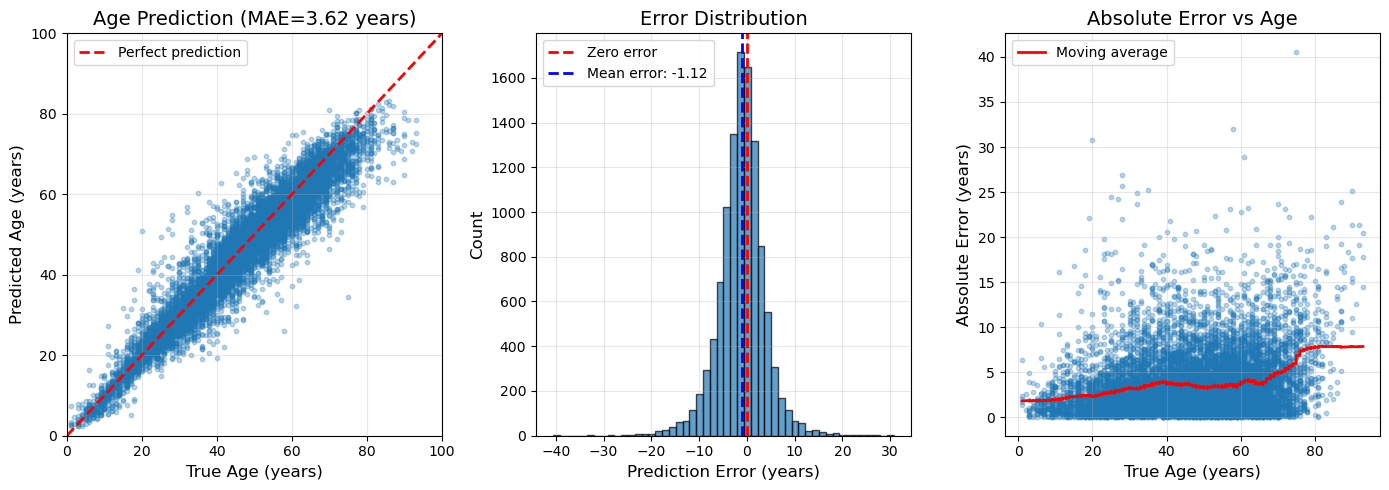

In [27]:
import numpy as np

# Convert tensors to numpy arrays
true_ages = test_targets
pred_ages = test_preds

if isinstance(true_ages, torch.Tensor):
    true_ages = true_ages.cpu().numpy()
elif isinstance(true_ages, list):
    true_ages = np.array(true_ages)

if isinstance(pred_ages, torch.Tensor):
    pred_ages = pred_ages.cpu().numpy()
elif isinstance(pred_ages, list):
    pred_ages = np.array(pred_ages)

# Get the MAE value from test_metrics
mae_value = test_metrics['mae']

# Visualize the results
visualize_age_predictions(true_ages, pred_ages, mae_value)


# Step 4: Run unit tests

##### In terminal: 
##### cd PyHealth
##### python tests/core/test_age_prediction.py (or whatever the directory is)